Text
====

Text is a domain that exemplifies:

* Large number of correlated features
* A domain where ordering issues are important
* Variable length feature vectors

Among the methods exemplified in text we will see:

* Feature selection: dimensionality reduction
* Feature weighting: TF-IDF
* Computable features: morphological features

Example Data
-------------

We will be using a 2011 dump of StackOverflow. In particular, we will be using the dump for the stats discussion board.
It is distributed as an XML file.

In [9]:
from lxml import etree
import sys
import re

posts = etree.parse("posts.xml")
root = posts.getroot()
rows = list(root.findall("./row"))
print("Total rows: ", len(rows))
print("\nFirst row: ", rows[0].attrib)
questions = list(root.findall("./row[@PostTypeId=\"1\"]"))
print("\nTotal questions: ", len(questions))
tags = list(map(lambda r:r.get("Tags").replace("<","").split(">")[:-1], questions))
docs = list(map(lambda r:re.sub("<\/?[^>]+>","",r.get("Title") + " " + r.get("Body")), questions))
print("\nFirst docs: ", docs[:10])
print("\nFirst tags: ", tags[:10])
tag_counts = dict()
for taglist in tags:
    for tag in taglist:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1
print("\nTotal tags: ", len(tag_counts))
sorted_tag_counts = sorted(list(tag_counts.items()),key=lambda t:t[1], reverse=True)
print("\nTop tags: ", sorted_tag_counts[:20])

Total rows:  14193

First row:  {'Id': '1', 'PostTypeId': '1', 'AcceptedAnswerId': '15', 'CreationDate': '2010-07-19T19:12:12.510', 'Score': '14', 'ViewCount': '388', 'Body': '<p>How should I elicit prior distributions from experts when fitting a Bayesian model?</p>\n', 'OwnerUserId': '8', 'LastActivityDate': '2010-09-15T21:08:26.077', 'Title': 'Eliciting priors from experts', 'Tags': '<bayesian><prior><elicitation>', 'AnswerCount': '5', 'CommentCount': '1', 'FavoriteCount': '7'}

Total questions:  4854

First docs:  ['Eliciting priors from experts How should I elicit prior distributions from experts when fitting a Bayesian model?\n', 'What is normality? In many different statistical methods there is an "assumption of normality".  What is "normality" and how do I know if there is normality?\n', 'What are some valuable Statistical Analysis open source projects? What are some valuable Statistical Analysis open source projects available right now?\n\nEdit: as pointed out by Sharpie, valua

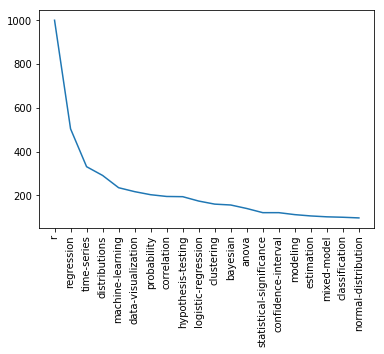

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.xticks(rotation=90)
plt.plot(list(map(lambda r:r[0], sorted_tag_counts[:20])), list(map(lambda r:r[1], sorted_tag_counts[:20])))

From the above, we will train two classifiers, one to tell questions related to _machine learning_ from the rest and another to tell questions related to _correlation_ from the rest.

We will turn now to the first approach, a histogram over words known as "BoW" or "Bag-of-Words"

In [11]:
from sklearn.model_selection import train_test_split

full_train_docs, test_docs, full_train_tags, test_tags = \
  train_test_split(docs, tags, test_size=0.3, random_state=42)
train_docs, devtest_docs, train_tags, devtest_tags = \
  train_test_split(full_train_docs, full_train_tags, test_size=0.2, random_state=42)

print("Full train length: ", len(full_train_docs))
print("Held out test length: ", len(test_docs))
print("Train length: ", len(train_docs))
print("DevTest length: ", len(devtest_docs))

Full train length:  3397
Held out test length:  1457
Train length:  2717
DevTest length:  680


Bag-of-words
--------------

The bag of words approach represents each document as a fixed size vector with size equals to the whole vocabulary (as computed on training).

By far the most important function in a bag-of-words approach is the tokenization function. Good tokenization is key and it is language and subdomain specific (e.g., journalistic text vs. Twitter).


In [12]:
def tokenize(text):
    return list(filter(lambda x:len(x)>0, 
                       re.sub('\s+',' ', re.sub('[^A-z]', ' ', text)).split(' ')))

print(tokenize(docs[0]))

['Eliciting', 'priors', 'from', 'experts', 'How', 'should', 'I', 'elicit', 'prior', 'distributions', 'from', 'experts', 'when', 'fitting', 'a', 'Bayesian', 'model']


### Word classes vs. word tokens

When operating with documents and vocabularies, it is important to distinguish the vocabulary size vs. the total document sizes. Both are measured in "words" but the term "word" means different things in each case. Therefore, in NLP we use the terms "word types" to refers to dictionary entries and "word tokens" to refer to document entries. You can think of the word types as a class in object oriented programming and a word token as an instance of the class.

We can now assemble the baseline system, where we are using BoW over the whole documents in the trainset. Because the vocabulary is fixed in the trainset, there will be many words missing in the devset. That is when smoothing techniques (like Good-Turing's smoothing) come handy.

In [13]:
tokenized_train_docs = list(map(tokenize, train_docs))
vocabulary = set([token for document in tokenized_train_docs for token in document])
sorted_vocabulary = sorted(list(vocabulary))
vocab_size = len(sorted_vocabulary)
word2pos = { w: i for i, w in enumerate(sorted_vocabulary) }
print("Vocabulary size: ", vocab_size)

print("\nI: ", word2pos['I'])
print("the: ", word2pos['the'])
print("The: ", word2pos['The'])
print("Bayesian: ", word2pos['Bayesian'])

Vocabulary size:  17873

I:  2091
the:  16503
The:  4612
Bayesian:  451


In [14]:
import numpy as np
xtrain = np.zeros((len(train_docs), vocab_size), dtype='float32')
ytrain_ml = np.zeros((len(train_docs),), dtype='float32')
ytrain_corr = np.zeros((len(train_docs),), dtype='float32')

for idx, toks in enumerate(tokenized_train_docs):
    for tok in toks:
        xtrain[idx][word2pos[tok]] += 1
    if 'correlation' in train_tags[idx]:
        ytrain_corr[idx] = 1.0
    if 'machine-learning' in train_tags[idx]:
        ytrain_ml[idx] = 1.0

In [15]:
from sklearn import svm

clf_corr = svm.SVC(kernel='linear')
clf_corr.fit(xtrain, ytrain_corr)

clf_ml = svm.SVC(kernel='linear')
clf_ml.fit(xtrain, ytrain_ml)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [16]:
from sklearn.metrics import precision_recall_fscore_support

ytrain_pred_corr = clf_corr.predict(xtrain)
prec, rec, f1, _ = precision_recall_fscore_support(ytrain_corr, ytrain_pred_corr)

print("[CORR on Training] Prec ", prec, "Rec", rec, "F1", f1)

ytrain_pred_ml = clf_ml.predict(xtrain)
prec, rec, f1, _ = precision_recall_fscore_support(ytrain_ml, ytrain_pred_ml)

print("[ML on Training] Prec ", prec, "Rec", rec, "F1", f1)

prec, rec, f1, _ = precision_recall_fscore_support(ytrain_ml, ytrain_pred_corr)
print("[ML on Training Corr] Prec ", prec, "Rec", rec, "F1", f1)

prec, rec, f1, _ = precision_recall_fscore_support(ytrain_corr, ytrain_pred_ml)
print("[CORR on Training ML] Prec ", prec, "Rec", rec, "F1", f1)

[CORR on Training] Prec  [1. 1.] Rec [1. 1.] F1 [1. 1.]
[ML on Training] Prec  [1. 1.] Rec [1. 1.] F1 [1. 1.]
[ML on Training Corr] Prec  [0.94712644 0.00934579] Rec [0.95888285 0.00719424] F1 [0.95296839 0.00813008]
[CORR on Training ML] Prec  [0.95888285 0.00719424] Rec [0.94712644 0.00934579] F1 [0.95296839 0.00813008]


In [17]:
tokenized_devtest_docs = list(map(tokenize, devtest_docs))

xdevtest = np.zeros((len(devtest_docs), vocab_size), dtype='float32')
ydevtest_corr = np.zeros((len(devtest_docs),), dtype='float32')
ydevtest_ml = np.zeros((len(devtest_docs),), dtype='float32')

for idx, toks in enumerate(tokenized_devtest_docs):
    for tok in toks:
        if tok in word2pos:
            xdevtest[idx][word2pos[tok]] += 1
    if 'correlation' in devtest_tags[idx]:
        ydevtest_corr[idx] = 1.0
    if 'machine-learning' in train_tags[idx]:
        ydevtest_ml[idx] = 1.0

In [18]:
ydevtest_pred_corr = clf_corr.predict(xdevtest)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_corr)

print("[CORR on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

ydevtest_pred_ml = clf_ml.predict(xdevtest)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_ml)

print("[ML on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_corr)
print("[ML on DevTest Corr] Prec ", prec, "Rec", rec, "F1", f1)

prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_ml)
print("[CORR on DevTest ML] Prec ", prec, "Rec", rec, "F1", f1)

[CORR on DevTest] Prec  [0.97268589 0.61904762] Rec [0.98767334 0.41935484] F1 [0.98012232 0.5       ]
[ML on DevTest] Prec  [0.95440729 0.04545455] Rec [0.96764253 0.03225806] F1 [0.96097934 0.03773585]
[ML on DevTest Corr] Prec  [0.95447648 0.04761905] Rec [0.96918336 0.03225806] F1 [0.9617737  0.03846154]
[CORR on DevTest ML] Prec  [0.95288754 0.        ] Rec [0.96610169 0.        ] F1 [0.95944912 0.        ]


### TF\*IDF

Instead of using raw counts, we can perform a traditional feature weighting employed in NLP/IR: adjust the counts by the inverse of the frequency of the word type over the corpus.

Therefore, we replace the Term Frequency (term is synonym with word type in IR) in the document with the TF times the Inverse Document Frequency (IDF). To have more informed statistics, we can compute the IDF counts on a larger set (e.g., Wikipedia or in our case, the whole StackOverflow dump). In this example we will use the train set.

In [19]:
import math

df = { tok: 0 for tok in vocabulary }
for toks in tokenized_train_docs:
    tokset = set(toks)
    for tok in tokset:
        df[tok] += 1
idf = dict()
for tok, count in df.items():
    idf[tok] = math.log(1.0 + len(train_docs) / count)

print("IDF 'the': ", idf['the'])
print("IDF 'Bayesian': ", idf['Bayesian'])

IDF 'the':  0.7368839286692329
IDF 'Bayesian':  3.771682770874293


In [20]:
xtrain_idf = np.zeros((len(train_docs), vocab_size), dtype='float32')

for idx, toks in enumerate(tokenized_train_docs):
    for tok in toks:
        xtrain_idf[idx][word2pos[tok]] += idf[tok]
# in practice, make a IDF vector and multiply xtrain instead
# or use scikit-learn TfidfVectorizer


clf_idf_corr = svm.SVC(kernel='linear')
clf_idf_corr.fit(xtrain_idf, ytrain_corr)

clf_idf_ml = svm.SVC(kernel='linear')
clf_idf_ml.fit(xtrain_idf, ytrain_ml)

xdevtest_idf = np.zeros((len(devtest_docs), vocab_size), dtype='float32')

for idx, toks in enumerate(tokenized_devtest_docs):
    for tok in toks:
        if tok in word2pos:
            xdevtest_idf[idx][word2pos[tok]] += idf[tok]

ydevtest_pred_idf_corr = clf_idf_corr.predict(xdevtest_idf)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_idf_corr)

print("[CORR IDF on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

ydevtest_pred_idf_ml = clf_idf_ml.predict(xdevtest_idf)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_idf_ml)

print("[ML IDF on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

[CORR IDF on DevTest] Prec  [0.97272727 0.65      ] Rec [0.98921418 0.41935484] F1 [0.98090145 0.50980392]
[ML IDF on DevTest] Prec  [0.95468278 0.05555556] Rec [0.97380586 0.03225806] F1 [0.9641495  0.04081633]


Given the size of the data, TF-IDF does not help in this case.

Morphological features
-------------------------

In some domains, it is useful to reduce the number of features by dropping the morphological variants for different words. For example, if we believe the word _prior_ is useful in our domain, its plural variant _priors_ might be equally useful but more rare. If we conflate both terms as the same feature, we could obtain better performance.

Larger text samples are needed to profit from this approach, though.

To obtain morphological roots for words, we can use a dictionary of root forms (a "lemmatizer" approach) or we can use simple approximation (a "stemmer" approach). 

We will use a stemming approach using an implementation of the Porter stemmer. 

In [23]:
from stemming.porter2 import stem as porter_stem

def tokenize_and_stem(text):
    return list(map(porter_stem, tokenize(text)))

print(tokenize(docs[0]))
print(tokenize_and_stem(docs[0]))

['Eliciting', 'priors', 'from', 'experts', 'How', 'should', 'I', 'elicit', 'prior', 'distributions', 'from', 'experts', 'when', 'fitting', 'a', 'Bayesian', 'model']
['Elicit', 'prior', 'from', 'expert', 'How', 'should', 'I', 'elicit', 'prior', 'distribut', 'from', 'expert', 'when', 'fit', 'a', 'Bayesian', 'model']


In [24]:
stemmed_train_docs = list(map(tokenize_and_stem, train_docs))
stemmed_vocabulary = set([token for document in stemmed_train_docs for token in document])
sorted_stemmed_vocabulary = sorted(list(stemmed_vocabulary))
stemmed_vocab_size = len(sorted_stemmed_vocabulary)
stem2pos = { s: i for i, s in enumerate(sorted_stemmed_vocabulary) }
print("Vocabulary size: ", vocab_size)
print("Stemmed Vocabulary size: ", stemmed_vocab_size)

print("\nI: ", stem2pos['I'])
print("the: ", stem2pos['the'])
print("Bayesian: ", stem2pos['Bayesian'])

Vocabulary size:  17873
Stemmed Vocabulary size:  13125

I:  1822
the:  12076
Bayesian:  401


In [25]:
xtrain_stem = np.zeros((len(train_docs), stemmed_vocab_size), dtype='float32')

for idx, stems in enumerate(stemmed_train_docs):
    for stem in stems:
        xtrain_stem[idx][stem2pos[stem]] += 1

clf_stem_corr = svm.SVC(kernel='linear')
clf_stem_corr.fit(xtrain_stem, ytrain_corr)

clf_stem_ml = svm.SVC(kernel='linear')
clf_stem_ml.fit(xtrain_stem, ytrain_ml)

stemmed_devtest_docs = list(map(tokenize_and_stem, devtest_docs))
xdevtest_stem = np.zeros((len(devtest_docs), stemmed_vocab_size), dtype='float32')

for idx, stems in enumerate(stemmed_devtest_docs):
    for stem in stems:
        if stem in stem2pos:
            xdevtest_stem[idx][stem2pos[stem]] += 1

ydevtest_pred_stem_corr = clf_stem_corr.predict(xdevtest_stem)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_stem_corr)

print("[CORR Stem on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

ydevtest_pred_stem_ml = clf_stem_ml.predict(xdevtest_stem)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_stem_ml)

print("[ML Stem on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

[CORR Stem on DevTest] Prec  [0.97720365 0.72727273] Rec [0.99075501 0.51612903] F1 [0.98393267 0.60377358]
[ML Stem on DevTest] Prec  [0.95426829 0.04166667] Rec [0.96456086 0.03225806] F1 [0.95938697 0.03636364]


In this dataset, stemming helps a little bit in one category but hurts in the other. Still, the variations are very small and probably not statistically significant.

Words in context
------------------

To incorporate some ordering among the words, a common technique is to use bigrams, pairs of words in order. If we were ot use bigrams directly, this will increase the vocabulary size quite a bit. We will combine bigrams with feature hashing to reduce the number of bigrams to a manageable size.

Let's first compute the total vocabulary size for all bigrams on the trainset.

In [26]:
all_bigrams = set([])

for toks in tokenized_train_docs:
    for idx in range(0,len(toks)):
        next_tok = "[PAD]"
        if idx < len(toks) - 1:
            next_tok = toks[idx+1]
        bigram = "%s-%s" % (toks[idx], next_tok)
        all_bigrams.add(bigram)
        
print("Total bigram count: ", len(all_bigrams))

Total bigram count:  161583


For hashing function, we will use Python's buit-in hashing function

In [27]:
print(hash("a-b"))
print(hash("%s-%s" % ("a","b")))

hashed_size = 10000

def custom_hash(x):
    return abs(hash(x)) % hashed_size 
    
print(custom_hash("a-b"))

1064118075059930475
1064118075059930475
475


In [28]:
xtrain_bigram = np.zeros((len(train_docs), hashed_size), dtype='float32')

for idx_doc, toks in enumerate(tokenized_train_docs):
    for idx in range(0,len(toks)):
        next_tok = "[PAD]"
        if idx < len(toks) - 1:
            next_tok = toks[idx+1]
        bigram = "%s-%s" % (toks[idx], next_tok)
        xtrain_bigram[idx_doc][custom_hash(bigram)] += 1

clf_bigram_corr = svm.SVC(kernel='linear')
clf_bigram_corr.fit(xtrain_bigram, ytrain_corr)

clf_bigram_ml = svm.SVC(kernel='linear')
clf_bigram_ml.fit(xtrain_bigram, ytrain_ml)

xdevtest_bigram = np.zeros((len(devtest_docs), hashed_size), dtype='float32')

for idx_doc, toks in enumerate(tokenized_devtest_docs):
    for idx in range(0,len(toks)):
        next_tok = "[PAD]"
        if idx < len(toks) - 1:
            next_tok = toks[idx+1]
        bigram = "%s-%s" % (toks[idx], next_tok)
        xdevtest_bigram[idx_doc][custom_hash(bigram)] += 1

ydevtest_pred_bigram_corr = clf_bigram_corr.predict(xdevtest_bigram)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_bigram_corr)

print("[CORR Bigram on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

ydevtest_pred_bigram_ml = clf_bigram_ml.predict(xdevtest_bigram)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_bigram_ml)

print("[ML Bigram on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

[CORR Bigram on DevTest] Prec  [0.96290801 1.        ] Rec [1.         0.19354839] F1 [0.98110355 0.32432432]
[ML Bigram on DevTest] Prec  [0.95529061 0.11111111] Rec [0.98767334 0.03225806] F1 [0.97121212 0.05      ]


It improves on _machine learning_ but it hurts on _correlation_. There is no free lunch.

Taboo features (stop words)
-------------------------------

A common feature selection technique in natural language processing is to drop a small set of highly frequent function words with little semantic content for classification tasks. This is called "stop word removal", an approach shared with information retrieval. We will use the [snowball list of stopwords](http://snowball.tartarus.org/algorithms/english/stop.txt).

In [29]:
stopwords = set(["i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself","yourselves",
                 "he","him","his","himself","she","her","hers","herself","it","its","itself","they","them","their",
                 "theirs","themselves","what","which","who","whom","this","that","these","those","am","is","are","was",
                 "were","be","been","being","have","has","had","having","do","does","did","doing","would","should",
                 "could","ought","i'm","you're","he's","she's","it's","we're","they're","i've","you've","we've",
                 "they've","i'd","you'd","he'd","she'd","we'd","they'd","i'll","you'll","he'll","she'll","we'll",
                 "they'll","isn't","aren't","wasn't","weren't","hasn't","haven't","hadn't","doesn't","don't",
                 "didn't","won't","wouldn't","shan't","shouldn't","can't","cannot","couldn't","mustn't","let's",
                 "that's","who's","what's","here's","there's","when's","where's","why's","how's","a","an","the",
                 "and","but","if","or","because","as","until","while","of","at","by","for","with","about","against",
                 "between","into","through","during","before","after","above","below","to","from","up","down","in",
                 "out","on","off","over","under","again","further","then","once","here","there","when","where","why",
                 "how","all","any","both","each","few","more","most","other","some","such","no","nor","not","only",
                 "own","same","so","than","too","very"])
def tokenize_and_filter_sb(text):
    return list(filter(lambda tok: tok.lower() not in stopwords, tokenize(text)))

print(tokenize(docs[0]))
print(tokenize_and_filter_sb(docs[0]))

['Eliciting', 'priors', 'from', 'experts', 'How', 'should', 'I', 'elicit', 'prior', 'distributions', 'from', 'experts', 'when', 'fitting', 'a', 'Bayesian', 'model']
['Eliciting', 'priors', 'experts', 'elicit', 'prior', 'distributions', 'experts', 'fitting', 'Bayesian', 'model']


In [30]:
cleaned_train_docs = list(map(tokenize_and_filter_sb, train_docs))
cleaned_vocabulary = set([token for document in cleaned_train_docs for token in document])
sorted_cleaned_vocabulary = sorted(list(cleaned_vocabulary))
cleaned_vocab_size = len(sorted_cleaned_vocabulary)
clean2pos = { s: i for i, s in enumerate(sorted_cleaned_vocabulary) }
print("Vocabulary size: ", vocab_size)
print("Cleaned Vocabulary size: ", cleaned_vocab_size)

print("\nI: ", clean2pos.get("I","NOT FOUND"))
print("the: ", clean2pos.get('the',"NOT FOUND"))
print("Bayesian: ", clean2pos['Bayesian'])

Vocabulary size:  17873
Cleaned Vocabulary size:  17616

I:  NOT FOUND
the:  NOT FOUND
Bayesian:  429


In [31]:
xtrain_clean = np.zeros((len(train_docs), cleaned_vocab_size), dtype='float32')

for idx, toks in enumerate(cleaned_train_docs):
    for tok in toks:
        xtrain_clean[idx][clean2pos[tok]] += 1

clf_clean_corr = svm.SVC(kernel='linear')
clf_clean_corr.fit(xtrain_clean, ytrain_corr)

clf_clean_ml = svm.SVC(kernel='linear')
clf_clean_ml.fit(xtrain_clean, ytrain_ml)

cleaned_devtest_docs = list(map(tokenize_and_filter_sb, devtest_docs))
xdevtest_clean = np.zeros((len(devtest_docs), cleaned_vocab_size), dtype='float32')

for idx, toks in enumerate(cleaned_devtest_docs):
    for tok in toks:
        if tok in clean2pos:
            xdevtest_clean[idx][clean2pos[tok]] += 1

ydevtest_pred_clean_corr = clf_clean_corr.predict(xdevtest_clean)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_clean_corr)

print("[CORR SB on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

ydevtest_pred_clean_ml = clf_clean_ml.predict(xdevtest_clean)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_clean_ml)

print("[ML SB on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

[CORR SB on DevTest] Prec  [0.97408537 0.58333333] Rec [0.98459168 0.4516129 ] F1 [0.97931034 0.50909091]
[ML SB on DevTest] Prec  [0.9543379  0.04347826] Rec [0.96610169 0.03225806] F1 [0.96018377 0.03703704]


Embeddings
------------

Finally, we explore using word embeddings. This problem is too small for meaningful embeddings so we don't expect them to be very useful here.

In [37]:
import gensim

embedding_size = 50
model = gensim.models.Word2Vec(tokenized_train_docs, size=embedding_size)
tok2vec = dict(zip(model.wv.index2word, model.wv.vectors))

print("Trained ", len(tok2vec), " embeddings")
print(tok2vec['Bayesian'])

Trained  5486  embeddings
[-0.5229744  -0.21847232 -0.35564885 -0.16526495  0.45997262  0.29393923
 -0.5376894   0.54118633  0.0292453  -0.6457027  -0.1534511   1.1785138
  0.6714278   0.4359652  -0.49339753  0.02450508  0.42765817  0.15296589
  0.03801096  0.15570013 -0.08122989  0.00431026  0.05533981  0.43047762
 -0.01900061  0.47528225  0.5498024  -0.00958453 -0.22836466 -0.63730276
 -0.53564155 -0.00971194 -0.21903953  0.10280292  0.48883933 -0.09598901
  0.36961237  0.05555241 -0.41219378  0.46536338  0.12845391 -0.4810625
  0.0381239  -0.13914423 -0.18192784  0.57800204  0.09995428  0.04612964
 -0.35730937  1.1358429 ]


In [38]:
from sklearn.manifold import TSNE

labels = []
tokens = []
for word in model.wv.vocab:
    tokens.append(model.wv[word])
    labels.append(word)
# 2500 iter is better
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

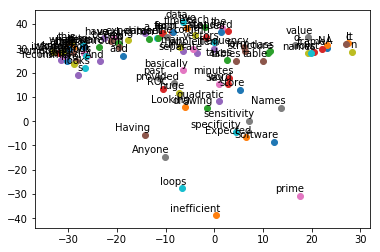

In [39]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure()
for i in range(min(100,len(x))):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

To use these embeddings, we take the average embedding for the whole document. We can also take the maximum and minimum for each coordinate, over all entries in the document.

In [40]:
xtrain_embed = np.zeros((len(train_docs), embedding_size), dtype='float32')

for idx, toks in enumerate(tokenized_train_docs):
    good_toks = list(filter(lambda t:t in tok2vec, toks))
    for tok in good_toks:
        tok_vect_scaled = np.copy(tok2vec[tok])
        tok_vect_scaled *= 1.0 / len(good_toks)
        xtrain_embed[idx,:] += tok_vect_scaled

print(xtrain_embed[0,:])

clf_embed_corr = svm.SVC(kernel='rbf')
clf_embed_corr.fit(xtrain_embed, ytrain_corr)

clf_embed_ml = svm.SVC(kernel='rbf')
clf_embed_ml.fit(xtrain_embed, ytrain_ml)

xdevtest_embed = np.zeros((len(devtest_docs), embedding_size), dtype='float32')

for idx, toks in enumerate(tokenized_devtest_docs):
    good_toks = list(filter(lambda t:t in tok2vec, toks))
    for tok in good_toks:
        tok_vect_scaled = np.copy(tok2vec[tok])
        tok_vect_scaled *= 1.0 / len(good_toks)
        xdevtest_embed[idx,:] += tok_vect_scaled

ydevtest_pred_embed_corr = clf_embed_corr.predict(xdevtest_embed)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_embed_corr)

print("[CORR Embed on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

ydevtest_pred_embed_ml = clf_embed_ml.predict(xdevtest_embed)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_embed_ml)

print("[ML Embed on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

[-0.31017736 -0.05628745  0.04742325 -0.22510795  0.10406617  0.35315272
 -0.5089115   0.21923469  0.11479017 -0.5114196  -0.00333385  0.6889952
  0.37617916  0.14917326 -0.6583154   0.34439927  0.3346753  -0.09024151
  0.05221294  0.06618482  0.13271913 -0.18265156  0.09730843  0.39782932
 -0.12373362  0.3511535   0.5043209  -0.08916581 -0.2657536  -0.66926026
 -0.6225683   0.13690093 -0.15283431 -0.11721498  0.7520093  -0.4382247
  0.34341082 -0.06496616 -0.49672255  0.39399573 -0.09052978 -0.42016673
 -0.21905951 -0.05216491 -0.06417383  0.31847614 -0.21432951  0.05036538
 -0.41903922  0.7238658 ]
[CORR Embed on DevTest] Prec  [0.95441176 0.        ] Rec [1. 0.] F1 [0.97667419 0.        ]
[ML Embed on DevTest] Prec  [0.95441176 0.        ] Rec [1. 0.] F1 [0.97667419 0.        ]


/home/juan/proyectos/feateng/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Other topics:

* SVD
* Representing syntactic trees or at least Title / Body relationship

# Respuestas comienzan aca

## Hipótesis

- Voy a probar como modelo optimo un [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). con kernel polynomico, Realmente no creo que se logre mejoras.
- Comence a utilizar justo donde se quedaron los features anteriores.
- Pense en filtrar datos agregando una serie de features random. Pero al parecer toda la clasificacion se da solamente por un feature (columna 9 (o 8 si contamos de 0)).

In [51]:
xtrain_embed = np.zeros((len(train_docs), embedding_size), dtype='float32')

for idx, toks in enumerate(tokenized_train_docs):
    good_toks = list(filter(lambda t:t in tok2vec, toks))
    for tok in good_toks:
        tok_vect_scaled = np.copy(tok2vec[tok])
        tok_vect_scaled *= 1.0 / len(good_toks)
        xtrain_embed[idx,:] += tok_vect_scaled

print(xtrain_embed[0,:])

clf_embed_corr = svm.SVC(kernel='poly')
clf_embed_corr.fit(xtrain_embed, ytrain_corr)

clf_embed_ml = svm.SVC(kernel='poly')
clf_embed_ml.fit(xtrain_embed, ytrain_ml)

xdevtest_embed = np.zeros((len(devtest_docs), embedding_size), dtype='float32')

for idx, toks in enumerate(tokenized_devtest_docs):
    good_toks = list(filter(lambda t:t in tok2vec, toks))
    for tok in good_toks:
        tok_vect_scaled = np.copy(tok2vec[tok])
        tok_vect_scaled *= 1.0 / len(good_toks)
        xdevtest_embed[idx,:] += tok_vect_scaled

ydevtest_pred_embed_corr = clf_embed_corr.predict(xdevtest_embed)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_embed_corr)

print("[CORR Embed on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

ydevtest_pred_embed_ml = clf_embed_ml.predict(xdevtest_embed)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_embed_ml)

print("[ML Embed on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

[-0.31017736 -0.05628745  0.04742325 -0.22510795  0.10406617  0.35315272
 -0.5089115   0.21923469  0.11479017 -0.5114196  -0.00333385  0.6889952
  0.37617916  0.14917326 -0.6583154   0.34439927  0.3346753  -0.09024151
  0.05221294  0.06618482  0.13271913 -0.18265156  0.09730843  0.39782932
 -0.12373362  0.3511535   0.5043209  -0.08916581 -0.2657536  -0.66926026
 -0.6225683   0.13690093 -0.15283431 -0.11721498  0.7520093  -0.4382247
  0.34341082 -0.06496616 -0.49672255  0.39399573 -0.09052978 -0.42016673
 -0.21905951 -0.05216491 -0.06417383  0.31847614 -0.21432951  0.05036538
 -0.41903922  0.7238658 ]
[CORR Embed on DevTest] Prec  [0.95441176 0.        ] Rec [1. 0.] F1 [0.97667419 0.        ]
[ML Embed on DevTest] Prec  [0.95441176 0.        ] Rec [1. 0.] F1 [0.97667419 0.        ]


/home/juan/proyectos/feateng/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Feature selection

In [59]:
from sklearn import feature_selection as fe

In [110]:
vt = fe.VarianceThreshold(0.053).fit(xtrain_embed)
flt_train = vt.transform(xtrain_embed)
flt_test = vt.transform(xdevtest_embed)

In [111]:
vt.variances_

array([0.02718188, 0.05049046, 0.00881962, 0.0100333 , 0.01967248,
       0.04671802, 0.04727959, 0.03691017, 0.05329538, 0.02203938,
       0.02537642, 0.03102347, 0.01748368, 0.01896288, 0.02021829,
       0.02633694, 0.00547984, 0.02463688, 0.01808461, 0.01831232,
       0.00943381, 0.01914003, 0.0252544 , 0.00884287, 0.00932604,
       0.04795623, 0.0157909 , 0.00994075, 0.01187072, 0.01429155,
       0.01795288, 0.01039362, 0.00724245, 0.01605798, 0.04047846,
       0.03207129, 0.00746386, 0.01466794, 0.01049367, 0.01746001,
       0.00890545, 0.01098153, 0.01319398, 0.01122363, 0.01084503,
       0.00736291, 0.02217276, 0.01619025, 0.01784013, 0.01362799])

In [97]:
clf_embed_corr = svm.SVC(kernel='poly')
clf_embed_corr.fit(flt_train, ytrain_corr)

clf_embed_ml = svm.SVC(kernel='poly')
clf_embed_ml.fit(flt_train, ytrain_ml)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [98]:
ydevtest_pred_embed_corr = clf_embed_corr.predict(flt_test)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_corr, ydevtest_pred_embed_corr)

print("[CORR Embed on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

ydevtest_pred_embed_ml = clf_embed_ml.predict(flt_test)
prec, rec, f1, _ = precision_recall_fscore_support(ydevtest_ml, ydevtest_pred_embed_ml)

print("[ML Embed on DevTest] Prec ", prec, "Rec", rec, "F1", f1)

[CORR Embed on DevTest] Prec  [0.95441176 0.        ] Rec [1. 0.] F1 [0.97667419 0.        ]
[ML Embed on DevTest] Prec  [0.95441176 0.        ] Rec [1. 0.] F1 [0.97667419 0.        ]


/home/juan/proyectos/feateng/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
